In [1]:
import os

# Change to the parent directory
os.chdir('../..')

# Verify the path using getcwd()
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1


## Building a NARX Neural Network

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from src.file_loader import load_csv_files
import matplotlib as mpl
import matplotlib.pyplot as pl

In [3]:
# Verify the path using getcwd()
cwd = os.getcwd()
print("Current working directory:", cwd)

Current working directory: c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1


In [4]:
# List of file names
file_names = [
    '9171_20241001_N11507060127_ Rapid polarization-2.csv'
    ]

# print(f"Processing file: {file_names}")
dataframes = load_csv_files(file_names, '', 'deep learning assignment')


In [5]:
# Extract the DataFrame
data = dataframes['9171_20241001_N11507060127__Rapid_polarization-2_csv']

# Confirm it's a DataFrame
print(type(data))  # Should output <class 'pandas.core.frame.DataFrame'>

# Use the describe() method
print(data.describe())


<class 'pandas.core.frame.DataFrame'>
       Time (HH:mm:ss.SSS) Channel     CH      V      A
count                16383   16341  16320  16320  16320
unique               16323   16321      2    142     16
top                   Step     CH1    CH1  2.926  2.251
freq                    21      21  16299   2120   5620


In [6]:
data.head()

,Time (HH:mm:ss.SSS),Channel,CH,V,A
0,11:45:54.513,0.780562,CH1,1.429,0.046
1,11:45:54.753,1.0206133,CH1,1.444,0.046
2,11:45:54.983,1.2505946,CH1,1.452,0.046
3,11:45:55.223,1.490689,CH1,1.457,0.046
4,11:45:55.453,1.7206743,CH1,1.461,0.046


In [7]:
data.dtypes

Time (HH:mm:ss.SSS)    object
Channel                object
CH                     object
V                      object
A                      object
dtype: object

In [8]:
# Convert `V` and `A` columns to numeric
data['V'] = pd.to_numeric(data['V'], errors='coerce')
data['A'] = pd.to_numeric(data['A'], errors='coerce')

In [9]:
# Drop rows with NaN values in these columns if conversion fails
data = data.dropna(subset=['V', 'A'])

In [10]:
# Select numeric columns
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
numeric_data = data[numeric_cols]

# Apply MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(numeric_data)

# Create a new DataFrame with scaled values
scaled_data = pd.DataFrame(scaled, columns=numeric_cols, index=data.index)

# Optional: Combine with non-numeric columns
non_numeric_cols = data.select_dtypes(exclude=['float64', 'int64'])
final_data = pd.concat([non_numeric_cols, scaled_data], axis=1)

# Check the result
print(final_data.head())


  Time (HH:mm:ss.SSS)    Channel   CH         V    A
0        11:45:54.513   0.780562  CH1  0.000000  0.0
1        11:45:54.753  1.0206133  CH1  0.007637  0.0
2        11:45:54.983  1.2505946  CH1  0.011711  0.0
3        11:45:55.223   1.490689  CH1  0.014257  0.0
4        11:45:55.453  1.7206743  CH1  0.016293  0.0


In [11]:
scaled_data.head()

,V,A
0,0.000000,0.0
1,0.007637,0.0
2,0.011711,0.0
3,0.014257,0.0
4,0.016293,0.0


In [12]:
final_data.head()

,Time (HH:mm:ss.SSS),Channel,CH,V,A
0,11:45:54.513,0.780562,CH1,0.000000,0.0
1,11:45:54.753,1.0206133,CH1,0.007637,0.0
2,11:45:54.983,1.2505946,CH1,0.011711,0.0
3,11:45:55.223,1.490689,CH1,0.014257,0.0
4,11:45:55.453,1.7206743,CH1,0.016293,0.0


In [13]:
def create_sequences(input_data, target_column, sequence_length=1, flatten=False):
    inputs = []
    targets = []
    data_size = len(input_data)
    
    for i in range(data_size-sequence_length):
        sequence = input_data[i:i+sequence_length]
        #print(type(sequence))
        label_position = i + sequence_length
        label = input_data[label_position][target_column]
        if flatten:
            inputs.append(sequence.flatten())
        else:
            inputs.append(sequence)
        targets.append(label)
        
    return np.array(inputs), np.array(targets)

In [14]:
x, y = create_sequences(scaled_data.to_numpy(), 1, 3, flatten=True)
x.shape, y.shape

((16296, 6), (16296,))

In [15]:
split_ratio = 0.25
split = int(len(x) * split_ratio)

x_train, x_valid = x[:-split], x[-split:]
y_train, y_valid = y[:-split], y[-split:]

In [16]:


# Assuming x.shape[1] is the number of input features
narx_model = keras.Sequential([
    layers.Dense(10, activation='tanh', input_shape=(x.shape[1],)),
    layers.Dense(1, activation='relu')
])

# Corrected: Wrap the metrics argument in a list
narx_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='mse',
    metrics=['mae']  # Wrap 'mae' in a list
)

# Adding an EarlyStopping callback
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)


c:\Users\onyer\OneDrive\Desktop\Research work\1. Projects\Battery_Analysis1\env_analysis\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
history = narx_model.fit(x,y, epochs=100, validation_split=0.2, verbose=1, callbacks=[callback])

Epoch 1/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2501 - mae: 0.3188 - val_loss: 0.0037 - val_mae: 0.0395
Epoch 2/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0026 - mae: 0.0335 - val_loss: 0.0013 - val_mae: 0.0244
Epoch 3/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.8010e-04 - mae: 0.0183 - val_loss: 0.0011 - val_mae: 0.0220
Epoch 4/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.6267e-04 - mae: 0.0180 - val_loss: 0.0011 - val_mae: 0.0200
Epoch 5/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.5136e-04 - mae: 0.0180 - val_loss: 9.9818e-04 - val_mae: 0.0192
Epoch 6/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.5357e-04 - mae: 0.0172 - val_loss: 9.4519e-04 - val_mae: 0.0182
Epoch 7/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 7.1638e-04 - mae: 0.0162 - val_loss: 8.8703e-04 - val_mae: 0.0170
Epoch 8/100
408/408 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.3691e-04 - mae: 0.0153 - val_loss: 7.9655e-04 - val_mae: 0.0133
Epoch 9/

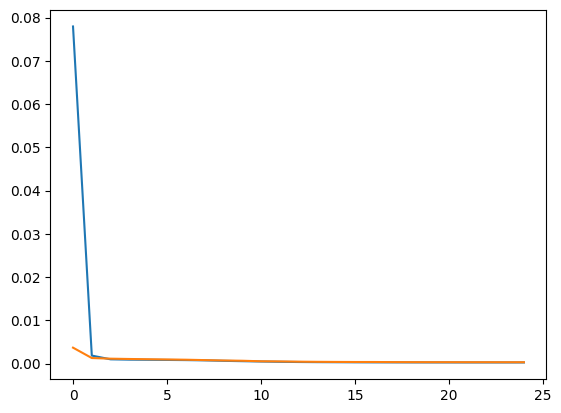

In [18]:
history.history['loss']

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [19]:
history.history['loss']

[0.07792478799819946,
 0.0018434791127219796,
 0.0009740899549797177,
 0.0008999547571875155,
 0.0008686270448379219,
 0.0008365136454813182,
 0.0007980678346939385,
 0.0007335924310609698,
 0.0006294540944509208,
 0.0005482417764142156,
 0.0004686246975325048,
 0.0004018311155959964,
 0.0003559652541298419,
 0.0003238376521039754,
 0.0003061980241909623,
 0.00028776164981536567,
 0.0002728327817749232,
 0.0002678549208212644,
 0.00026016621268354356,
 0.00025491276755928993,
 0.0002521190035622567,
 0.00024822025443427265,
 0.0002482558775227517,
 0.0002482935960870236,
 0.0002499868278391659]

In [20]:
predicted = narx_model(x)

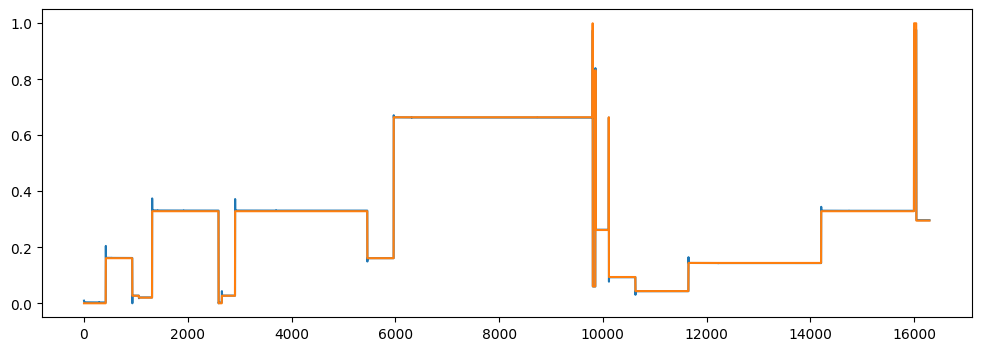

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(predicted)
plt.plot(y)

In [22]:
narx_model.evaluate(x,y)

510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4329e-04 - mae: 0.0020


[0.0002476696972735226, 0.0017726959194988012]